# **Sales Volume Prediction Analysis**

In [1]:
# Suppress warnings (for cleaner report)
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy.stats import pearsonr, ttest_ind, shapiro, kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Machine learning - Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep learning - TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Deep learning - PyTorch (TabNet)
import torch
from pytorch_tabnet.tab_model import TabNetRegressor


2024-11-12 03:32:57.298896: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Loading the data into a pandas DataFrame
df = pd.read_csv('./data/raw_data.csv')


## **Data Wrangling**

### **Data Assessment**
#### **Basic Data Exploration**

In [3]:
# Checking the data structure, column types, and non-null counts
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        252 non-null    int64  
 1   Product Position  252 non-null    object 
 2   Promotion         252 non-null    object 
 3   Product Category  252 non-null    object 
 4   Seasonal          252 non-null    object 
 5   Sales Volume      252 non-null    int64  
 6   brand             252 non-null    object 
 7   url               252 non-null    object 
 8   sku               252 non-null    object 
 9   name              251 non-null    object 
 10  description       250 non-null    object 
 11  price             252 non-null    float64
 12  currency          252 non-null    object 
 13  scraped_at        252 non-null    object 
 14  terms             252 non-null    object 
 15  section           252 non-null    object 
dtypes: float64(1), int64(2), object(13)
memory u

#### **Preview Data**

In [4]:
# Displaying the first few rows to understand data structure and values
print("First five rows of the dataset:")
display(df.head())


First five rows of the dataset:


,Product ID,Product Position,Promotion,Product Category,Seasonal,Sales Volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section
0,185102,Aisle,No,Clothing,No,2823,Zara,https://www.zara.com/us/en/basic-puffer-jacket...,272145190-250-2,BASIC PUFFER JACKET,Puffer jacket made of tear-resistant ripstop f...,19.99,USD,2024-02-19T08:50:05.654618,jackets,MAN
1,188771,Aisle,No,Clothing,No,654,Zara,https://www.zara.com/us/en/tuxedo-jacket-p0889...,324052738-800-46,TUXEDO JACKET,Straight fit blazer. Pointed lapel collar and ...,169.00,USD,2024-02-19T08:50:06.590930,jackets,MAN
2,180176,End-cap,Yes,Clothing,Yes,2220,Zara,https://www.zara.com/us/en/slim-fit-suit-jacke...,335342680-800-44,SLIM FIT SUIT JACKET,Slim fit jacket. Notched lapel collar. Long sl...,129.00,USD,2024-02-19T08:50:07.301419,jackets,MAN
3,112917,Aisle,Yes,Clothing,Yes,1568,Zara,https://www.zara.com/us/en/stretch-suit-jacket...,328303236-420-44,STRETCH SUIT JACKET,Slim fit jacket made of viscose blend fabric. ...,129.00,USD,2024-02-19T08:50:07.882922,jackets,MAN
4,192936,End-cap,No,Clothing,Yes,2942,Zara,https://www.zara.com/us/en/double-faced-jacket...,312368260-800-2,DOUBLE FACED JACKET,Jacket made of faux leather faux shearling wit...,139.00,USD,2024-02-19T08:50:08.453847,jackets,MAN


In [5]:
# Displaying the last few rows to check for any structural inconsistencies
print("\nLast five rows of the dataset:")
display(df.tail())



Last five rows of the dataset:


,Product ID,Product Position,Promotion,Product Category,Seasonal,Sales Volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section
247,159182,Front of Store,Yes,Clothing,No,1014,Zara,https://www.zara.com/us/en/basic-100-wool-swea...,321993245-500-2,FAUX LEATHER OVERSIZED JACKET LIMITED EDITION,Jacket made of technical fabric with padded in...,169.00,USD,2024-02-19T09:10:43.883037,jackets,MAN
248,199233,Aisle,Yes,Clothing,No,2222,Zara,https://www.zara.com/us/en/colorblock-knit-cro...,330590505-500-2,CONTRASTING PATCHES BOMBER JACKET,Oversized jacket. Notched lapel collar and lon...,159.00,USD,2024-02-19T09:10:44.463883,jackets,MAN
249,137044,Aisle,No,Clothing,Yes,2534,Zara,https://www.zara.com/us/en/hooded-technical-ja...,320680326-107-39,PATCH BOMBER JACKET,Varsity jacket with elastic collar and long sl...,12.99,USD,2024-02-19T09:10:45.009106,jackets,MAN
250,154736,Front of Store,Yes,Clothing,Yes,1466,Zara,https://www.zara.com/us/en/houndstooth-suit-ja...,311292244-800-39,CROPPED BOMBER JACKET LIMITED EDITION,Varsity jacket with padded interior. Rib elast...,19.90,USD,2024-02-19T09:10:45.631804,jackets,MAN
251,141434,Front of Store,No,Clothing,Yes,2870,Zara,https://www.zara.com/us/en/bomber-jacket-p0534...,311307610-400-39,FAUX LEATHER PUFFER JACKET,Jacket with lightly padded interior. Rib colla...,39.90,USD,2024-02-19T09:10:31.877972,jackets,MAN


#### **Summary Statistics**

In [6]:
# Generating summary statistics for numeric columns
print("\nSummary statistics for numerical columns:")
display(df.describe())



Summary statistics for numerical columns:


,Product ID,Sales Volume,price
count,252.000000,252.000000,252.000000
mean,153370.503968,1823.702381,86.252540
std,26160.444549,697.703748,52.083205
min,110075.000000,529.000000,7.990000
25%,131053.750000,1243.000000,49.900000
50%,151681.500000,1839.500000,79.900000
75%,175669.750000,2398.750000,109.000000
max,199631.000000,2989.000000,439.000000


#### **Checking for Missing Values**

In [7]:
# Summing null values in each column to identify missing data
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
Product ID          0
Product Position    0
Promotion           0
Product Category    0
Seasonal            0
Sales Volume        0
brand               0
url                 0
sku                 0
name                1
description         2
price               0
currency            0
scraped_at          0
terms               0
section             0
dtype: int64


#### **Checking for Duplicates**

In [8]:
# Checking for duplicated rows in the dataset
num_duplicates = df.duplicated().sum()
print(f"\nTotal duplicated rows: {num_duplicates}")



Total duplicated rows: 0


#### **Unique Values in Each Column**

In [9]:
# Counting unique values in each column to assess data variety and potential redundancies
print("\nUnique values per column:")
print(df.nunique())



Unique values per column:
Product ID          252
Product Position      3
Promotion             2
Product Category      1
Seasonal              2
Sales Volume        234
brand                 1
url                 228
sku                 228
name                194
description         221
price                28
currency              1
scraped_at          229
terms                 5
section               2
dtype: int64


#### **Identifying Duplicates in Specific Columns**

In [10]:
# Checking for duplicate `sku` and `url` entries specifically
print(f"\nNumber of duplicated 'sku' values: {df['sku'].duplicated().sum()}")
print(f"Number of duplicated 'url' values: {df['url'].duplicated().sum()}")



Number of duplicated 'sku' values: 24
Number of duplicated 'url' values: 24


In [11]:
# Confirm if duplicated entries in `sku` also appear duplicated in `url`
sku_duplicates = df[df['sku'].duplicated()]
url_duplicates = df[df['url'].duplicated()]
print("\nDo 'sku' duplicates match 'url' duplicates?")
print(sku_duplicates.equals(url_duplicates))



Do 'sku' duplicates match 'url' duplicates?
True


In [12]:
# Displaying a few duplicate rows based on `sku` to examine potential data discrepancies
print("\nSample rows with duplicate 'sku' values:")
display(df[df['sku'].duplicated(keep=False)].sort_values(by='sku').head(4))



Sample rows with duplicate 'sku' values:


,Product ID,Product Position,Promotion,Product Category,Seasonal,Sales Volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section
244,118985,Aisle,No,Clothing,Yes,694,Zara,https://www.zara.com/us/en/basic-knit-sweater-...,281593208-015-2,PATCH BOMBER JACKET,Vest made of viscose and wool blend fabric. V-...,139.00,USD,2024-02-19T09:10:42.016223,t-shirts,MAN
125,183825,Aisle,Yes,Clothing,Yes,2989,Zara,https://www.zara.com/us/en/plaid-tie-dye-overs...,281593208-015-2,PLAID TIE DYE OVERSHIRT,Regular fit overshirt made of cotton. Lapel co...,19.99,USD,2024-02-19T08:51:41.127759,jackets,MAN
242,177771,End-cap,Yes,Clothing,Yes,1764,Zara,https://www.zara.com/us/en/contrast-topstitchi...,281883711-071-2,SUIT JACKET,Jacket with lightly padded interior. Corduroy ...,69.90,USD,2024-02-19T09:10:40.681401,t-shirts,MAN
123,183537,Front of Store,Yes,Clothing,Yes,2434,Zara,https://www.zara.com/us/en/paint-print-overshi...,281883711-071-2,PAINT PRINT OVERSHIRT,Relaxed fit overshirt. Lapel collar and long s...,19.99,USD,2024-02-19T08:51:40.120546,jackets,MAN


#### **Visualizing Data Distribution**


Histogram for numerical columns:


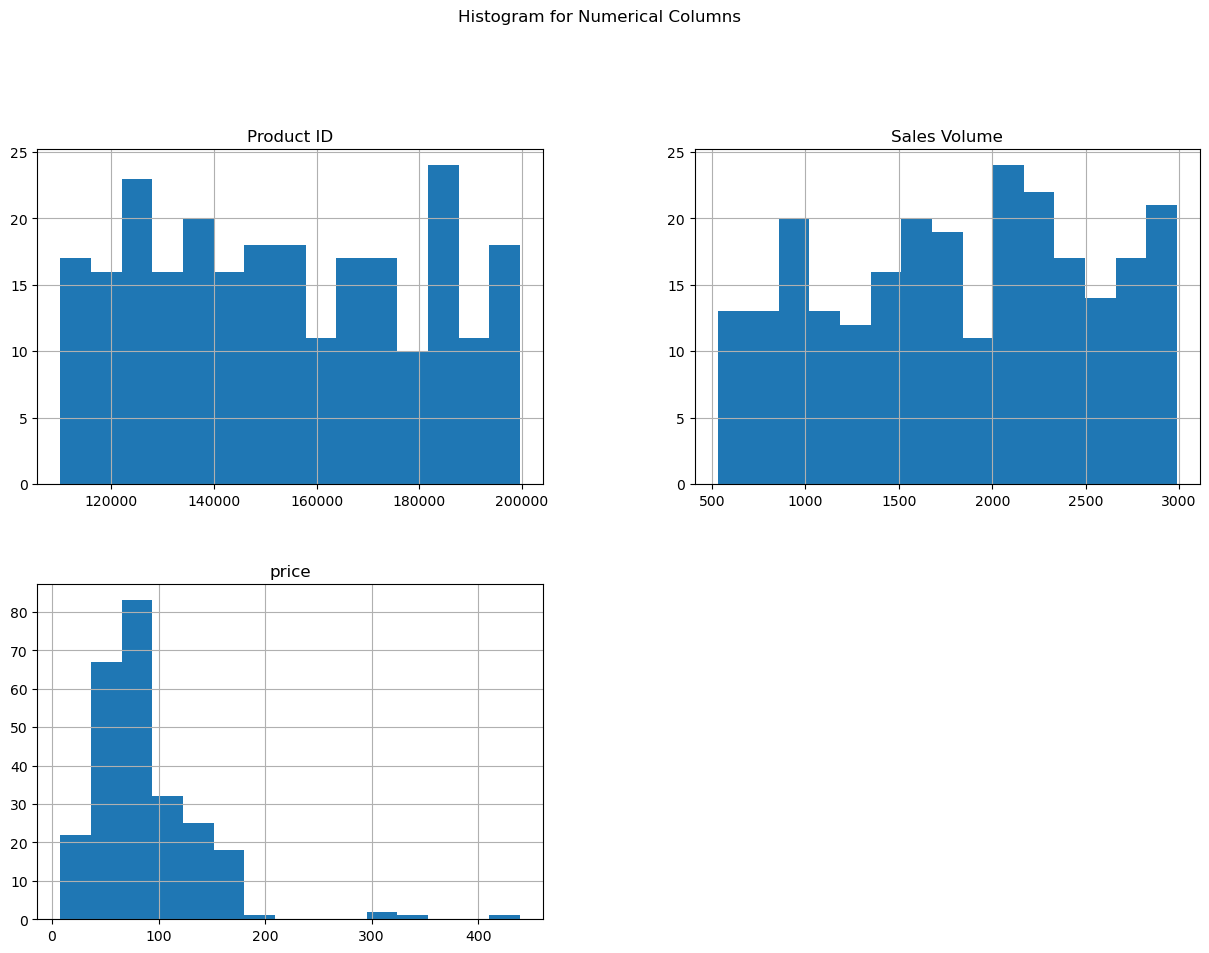

In [13]:
# Plotting histogram of numerical data to check distribution and skewness
print("\nHistogram for numerical columns:")
df.hist(bins=15, figsize=(15, 10))
plt.suptitle("Histogram for Numerical Columns", y=1.02)
plt.show()



Boxplot for 'price' column:


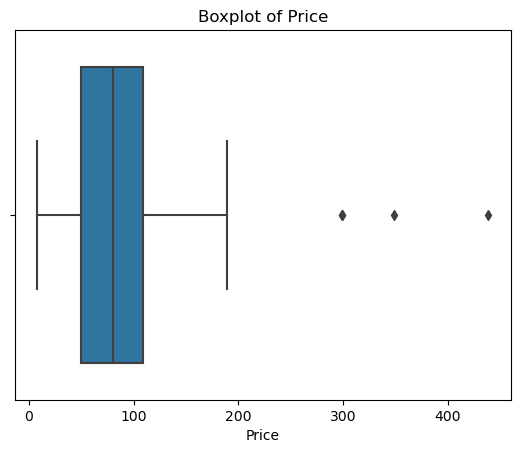

In [14]:
# Boxplot to visually inspect `price` distribution and identify outliers
print("\nBoxplot for 'price' column:")
sns.boxplot(x=df['price'])
plt.title("Boxplot of Price")
plt.xlabel("Price")
plt.show()


#### **Data Quality and Tidiness Assessment**

**Overview**  
The dataset consists of 252 rows and 17 columns. This report provides an analysis of identified quality and tidiness issues based on the dataset’s structure and contents.

##### **Quality Issues**

1. **Missing Values**:
   - The `name` column contains 1 missing value.
   - The `description` column has 2 missing values.

2. **Timestamp Format**:
   - The `scraped_at` column stores timestamps as strings. Converting this column to a datetime format would improve functionality for time-based analysis.

3. **Potential Outlier Issues**:
   - The `price` distribution is right-skewed due to outliers. These outliers may represent valuable information and will be retained initially, unless they are found to degrade model performance.

##### **Tidiness Issues**

1. **Redundant Columns**:
   - Some columns do not provide meaningful information due to lack of variability:
     - The `currency` column contains only one unique value (`USD`).
     - The `brand` column has only a single unique value (`Zara`).
     - The `Product Category` column also has only one unique value (`Clothing`).



### **Data Cleaning**

In [15]:
# Creating a copy of the original DataFrame to avoid altering the original data
df_cleaned = df.copy()


#### **Removing Redundant Columns**

In [16]:
# Dropping columns identified as redundant due to low variability:
# `currency`, `brand`, `Product Category` - These columns contain only one unique value and 
# add no additional information to the model.
redundant_columns = ['currency', 'brand', 'Product Category']
df_cleaned = df_cleaned.drop(columns=redundant_columns)
print("Redundant columns removed. Remaining columns:")
print(df_cleaned.columns)


Redundant columns removed. Remaining columns:
Index(['Product ID', 'Product Position', 'Promotion', 'Seasonal',
       'Sales Volume', 'url', 'sku', 'name', 'description', 'price',
       'scraped_at', 'terms', 'section'],
      dtype='object')


In [17]:
# Assertion to confirm columns were removed
assert all(col not in df_cleaned.columns for col in redundant_columns), "Redundant columns were not removed successfully."

#### **Handling Missing Values**

In [18]:
# Dropping rows with any missing values in `name` and `description` as the number of missing values is minimal.
df_cleaned = df_cleaned.dropna(subset=['name', 'description'])
print(f"\nRows with missing 'name' or 'description' dropped. Remaining rows: {df_cleaned.shape[0]}")



Rows with missing 'name' or 'description' dropped. Remaining rows: 250


In [19]:
# Assertion to confirm missing values were handled
assert df_cleaned['name'].isnull().sum() == 0, "There are still missing values in 'name'."
assert df_cleaned['description'].isnull().sum() == 0, "There are still missing values in 'description'."


#### **Converting Timestamp Column to Datetime Format**

In [20]:
# Converting `scraped_at` from string format to datetime format for time-based analysis.
df_cleaned['scraped_at'] = pd.to_datetime(df_cleaned['scraped_at'])
print("\n'scraped_at' column converted to datetime format.")



'scraped_at' column converted to datetime format.


In [21]:
# Assertion to confirm datetime conversion
assert pd.api.types.is_datetime64_any_dtype(df_cleaned['scraped_at']), "'scraped_at' column is not in datetime format."


#### **Converting Column Names to Snake Case**

In [22]:
# Converting all column names to snake_case for consistent and accessible naming
df_cleaned.columns = df_cleaned.columns.str.lower().str.replace(' ', '_')



In [23]:
# Assertion to confirm column names are in snake case
assert all('_' in col or col.islower() for col in df_cleaned.columns), "Not all column names are in snake_case."


In [24]:
# Verifying the final column names
print(df_cleaned.columns)


Index(['product_id', 'product_position', 'promotion', 'seasonal',
       'sales_volume', 'url', 'sku', 'name', 'description', 'price',
       'scraped_at', 'terms', 'section'],
      dtype='object')


#### **Dimensionality Reduction**

In [25]:
# `scrapped_at` column has no use in this analysis
df_cleaned = df_cleaned.drop('scraped_at', axis=1)


In [26]:
# Verifying the column drop
assert 'scraped_at' not in df_cleaned.columns

#### **Final Verification**

In [27]:
# Checking the final structure of the cleaned DataFrame.
print("\nFinal structure of cleaned data:")
df_cleaned.info()



Final structure of cleaned data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 251
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        250 non-null    int64  
 1   product_position  250 non-null    object 
 2   promotion         250 non-null    object 
 3   seasonal          250 non-null    object 
 4   sales_volume      250 non-null    int64  
 5   url               250 non-null    object 
 6   sku               250 non-null    object 
 7   name              250 non-null    object 
 8   description       250 non-null    object 
 9   price             250 non-null    float64
 10  terms             250 non-null    object 
 11  section           250 non-null    object 
dtypes: float64(1), int64(2), object(9)
memory usage: 25.4+ KB


In [28]:
# Displaying the first few rows of the cleaned data for inspection.
print("\nFirst few rows of cleaned data:")
display(df_cleaned.head())



First few rows of cleaned data:


,product_id,product_position,promotion,seasonal,sales_volume,url,sku,name,description,price,terms,section
0,185102,Aisle,No,No,2823,https://www.zara.com/us/en/basic-puffer-jacket...,272145190-250-2,BASIC PUFFER JACKET,Puffer jacket made of tear-resistant ripstop f...,19.99,jackets,MAN
1,188771,Aisle,No,No,654,https://www.zara.com/us/en/tuxedo-jacket-p0889...,324052738-800-46,TUXEDO JACKET,Straight fit blazer. Pointed lapel collar and ...,169.00,jackets,MAN
2,180176,End-cap,Yes,Yes,2220,https://www.zara.com/us/en/slim-fit-suit-jacke...,335342680-800-44,SLIM FIT SUIT JACKET,Slim fit jacket. Notched lapel collar. Long sl...,129.00,jackets,MAN
3,112917,Aisle,Yes,Yes,1568,https://www.zara.com/us/en/stretch-suit-jacket...,328303236-420-44,STRETCH SUIT JACKET,Slim fit jacket made of viscose blend fabric. ...,129.00,jackets,MAN
4,192936,End-cap,No,Yes,2942,https://www.zara.com/us/en/double-faced-jacket...,312368260-800-2,DOUBLE FACED JACKET,Jacket made of faux leather faux shearling wit...,139.00,jackets,MAN


#### **Storing Cleaned Dataset**

In [29]:
# Saving the cleaned DataFrame to a new CSV file for future use
output_file = './data/cleaned_data.csv'
df_cleaned.to_csv(output_file, index=False)
print(f"\nCleaned data has been saved to '{output_file}'.")


Cleaned data has been saved to './data/cleaned_data.csv'.


## **Exploratory Data Analysis (EDA)**

### **Sales Volume Patterns**

1. What does the overall distribution of `sales_volume` look like?
2. How does `sales_volume` vary across product_position categories (Aisle, End-cap, Front of Store)?
3. Does the effect of `product_position` on `sales_volume` change depending on whether a product is on promotion?


Mean Sales Volume: 1822.22
Median Sales Volume: 1836.50
Shapiro-Wilk Test for Normality: W = 0.9569, p-value = 0.0000


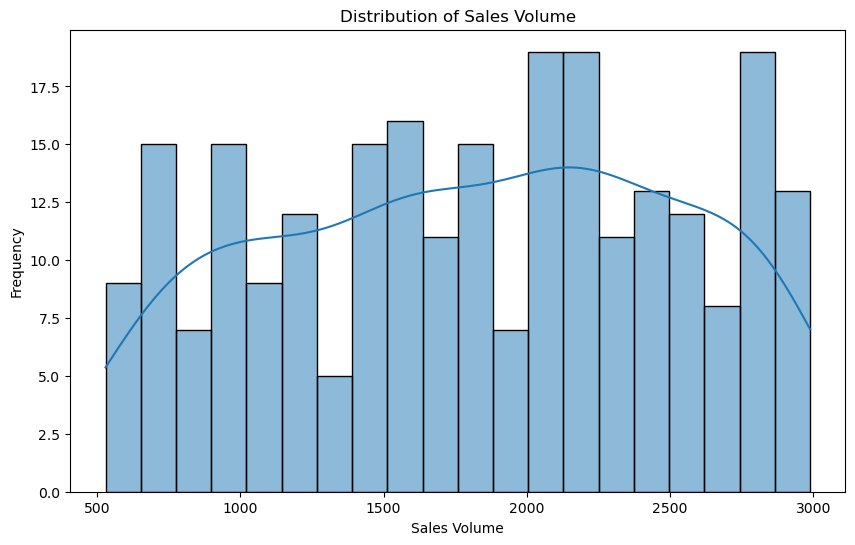

In [30]:
# ================================================
# 1. Sales Volume Distribution
# ================================================

# Calculating summary statistics for sales volume
sales_volume_mean = df_cleaned['sales_volume'].mean()
sales_volume_median = df_cleaned['sales_volume'].median()
print(f"Mean Sales Volume: {sales_volume_mean:.2f}")
print(f"Median Sales Volume: {sales_volume_median:.2f}")

# Checking normality with Shapiro-Wilk test
shapiro_stat, shapiro_p = shapiro(df_cleaned['sales_volume'])
print(f"Shapiro-Wilk Test for Normality: W = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# Plotting histogram and KDE for sales volume distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['sales_volume'], bins=20, kde=True)
plt.title("Distribution of Sales Volume")
plt.xlabel("Sales Volume")
plt.ylabel("Frequency")
plt.show()



Mean and Median Sales Volume by Product Position:
                         mean  median
product_position                     
Aisle             1828.824742  1791.0
End-cap           1772.773810  1771.0
Front of Store    1873.144928  2067.0

Kruskal-Wallis Test for Sales Volume by Product Position: H = 0.90, p-value = 0.6367


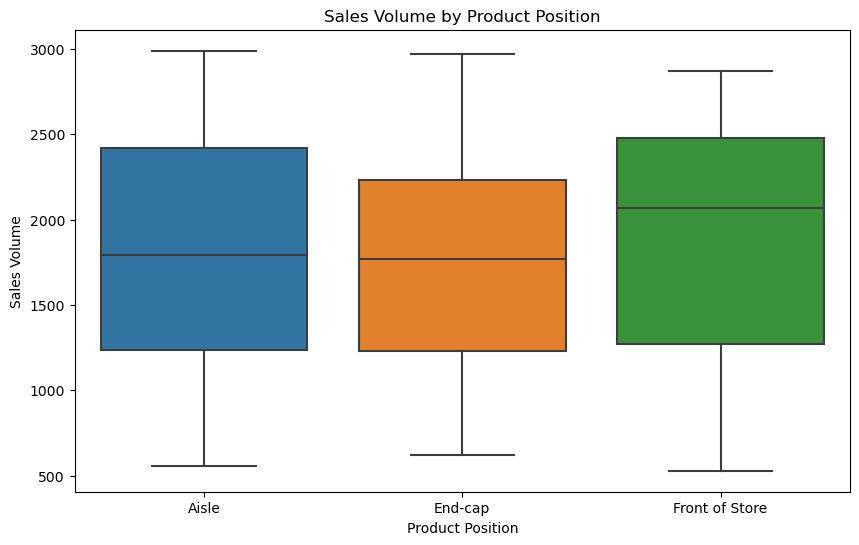

In [31]:
# ================================================
# 2. Sales by Product Position
# ================================================

# Calculating mean and median sales volume for each product position
position_stats = df_cleaned.groupby('product_position')['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Product Position:")
print(position_stats)

# Conducting Kruskal-Wallis test (non-parametric) for sales volume across product positions
kruskal_stat, kruskal_p = kruskal(
    df_cleaned[df_cleaned['product_position'] == 'Aisle']['sales_volume'],
    df_cleaned[df_cleaned['product_position'] == 'End-cap']['sales_volume'],
    df_cleaned[df_cleaned['product_position'] == 'Front of Store']['sales_volume']
)
print(f"\nKruskal-Wallis Test for Sales Volume by Product Position: H = {kruskal_stat:.2f}, p-value = {kruskal_p:.4f}")

# Plotting boxplot for sales volume by product position
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='product_position', y='sales_volume')
plt.title("Sales Volume by Product Position")
plt.xlabel("Product Position")
plt.ylabel("Sales Volume")
plt.show()



Mean and Median Sales Volume by Product Position and Promotion Status:
                                   mean  median
product_position promotion                     
Aisle            No         1861.509804  1796.0
                 Yes        1792.586957  1771.5
End-cap          No         1690.318182  1638.5
                 Yes        1863.475000  2050.0
Front of Store   No         1918.945946  2063.0
                 Yes        1820.187500  2151.5

Two-way ANOVA for Sales Volume by Product Position and Promotion Status:
                                        sum_sq     df         F    PR(>F)
C(product_position)               3.888980e+05    2.0  0.392897  0.675525
C(promotion)                      1.139811e+03    1.0  0.002303  0.961763
C(product_position):C(promotion)  9.093313e+05    2.0  0.918681  0.400421
Residual                          1.207584e+08  244.0       NaN       NaN


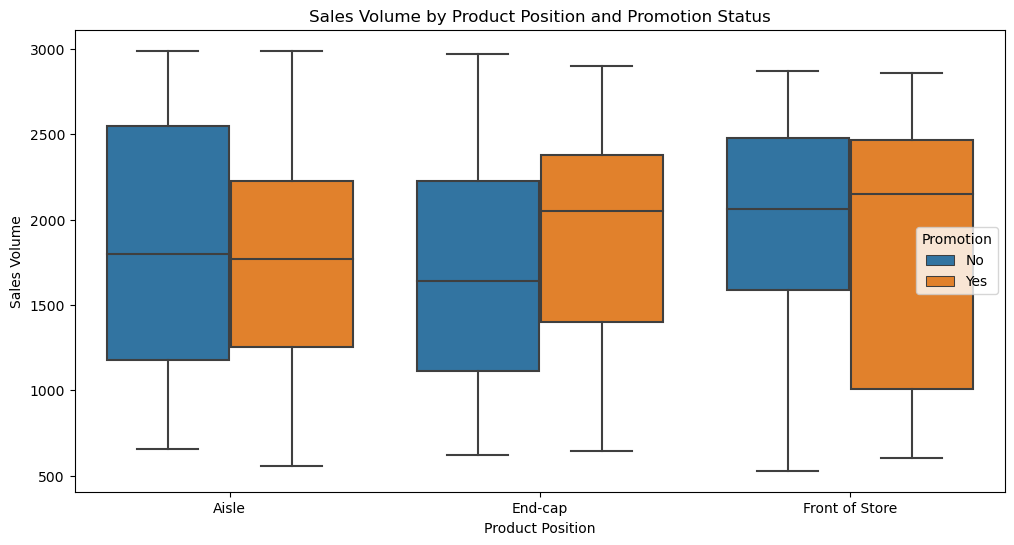

In [32]:
# ================================================
# 3. Interaction Between Product Position and Promotion
# ================================================

# Calculating mean and median sales volume for each combination of product position and promotion status
position_promotion_stats = df_cleaned.groupby(['product_position', 'promotion'])['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Product Position and Promotion Status:")
print(position_promotion_stats)

# Performing two-way ANOVA for interaction between product position and promotion on sales volume
model = ols('sales_volume ~ C(product_position) * C(promotion)', data=df_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nTwo-way ANOVA for Sales Volume by Product Position and Promotion Status:")
print(anova_table)

# Plotting boxplot for sales volume by product position and promotion status
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='product_position', y='sales_volume', hue='promotion')
plt.title("Sales Volume by Product Position and Promotion Status")
plt.xlabel("Product Position")
plt.ylabel("Sales Volume")
plt.legend(title="Promotion")
plt.show()


#### **Insights Regarding Sales Volume Patterns**

1. **Sales Volume Distribution**:  
   - **Observations**: The mean and median sales volumes are similar (1822 and 1836, respectively), suggesting a fairly balanced distribution. However, the Shapiro-Wilk test indicates that `sales_volume` is not normally distributed (p < 0.0001).
   - **Visualization**: The histogram confirms a fairly even spread across the range, with no clear skew.
   - **Conclusion**: Since `sales_volume` isn’t normally distributed, non-parametric tests are appropriate for comparing groups.

2. **Sales by Product Position**:  
   - **Observations**: Sales volumes are fairly consistent across positions, with Front of Store showing a slightly higher median (2067) compared to Aisle and End-cap.
   - **Statistical Test**: The Kruskal-Wallis test finds no significant difference in sales volume across product positions (p = 0.64).
   - **Visualization**: The boxplot confirms similar sales volumes across positions, with a slightly higher median for Front of Store.
   - **Conclusion**: Product position doesn’t have a statistically significant impact on sales volume in this dataset.

3. **Interaction Between Product Position and Promotion**:  
   - **Observations**: The mean and median sales volumes are relatively close across different combinations of `product_position` and `promotion`. No clear pattern suggests that promotions boost sales differently across positions.
   - **Statistical Test**: A two-way ANOVA finds no significant interaction between `product_position` and `promotion` on `sales_volume` (p = 0.40).
   - **Visualization**: The grouped boxplot shows similar sales volumes across positions and promotion statuses, with no notable differences.
   - **Conclusion**: Promotions do not appear to influence sales differently across product positions, indicating that neither position nor promotion has a major impact on sales in this dataset.

##### **Summary**
Overall, `product_position` and `promotion` don’t significantly affect `sales_volume`. Sales remain consistent across product positions and show no clear boost from promotions, either overall or in specific positions.

### **Impact of Price on Sales**

1. Is there a correlation between `price` and `sales_volume`?
2. How does `sales_volume` vary across different `price` ranges?
3. Is there a difference in `sales_volume` between promoted and non-promoted items within specific `price` ranges? 

Pearson Correlation between Price and Sales Volume: -0.08 (p-value: 0.1923)


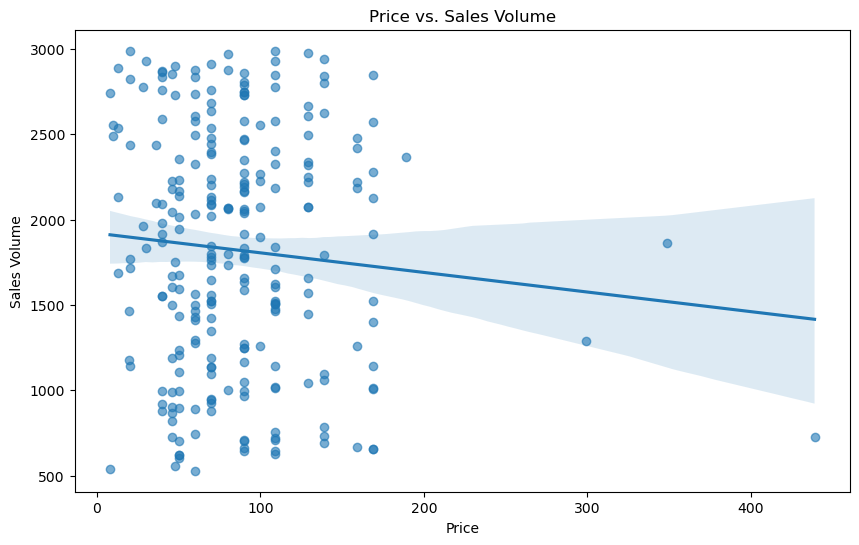

In [33]:
# ================================================
# 1. Price vs. Sales Volume Correlation
# ================================================

# Calculating Pearson correlation coefficient
correlation, p_value = pearsonr(df_cleaned['price'], df_cleaned['sales_volume'])
print(f"Pearson Correlation between Price and Sales Volume: {correlation:.2f} (p-value: {p_value:.4f})")

# Plotting scatter plot with regression line for visualizing correlation
plt.figure(figsize=(10, 6))
sns.regplot(data=df_cleaned, x='price', y='sales_volume', scatter_kws={'alpha':0.6})
plt.title("Price vs. Sales Volume")
plt.xlabel("Price")
plt.ylabel("Sales Volume")
plt.show()



Mean and Median Sales Volume by Price Range:
                mean  median
price                       
0-50     1800.859155  1831.0
50-100   1874.327103  1917.0
100-150  1810.560000  1685.0
150-200  1722.894737  1916.0
200+     1293.000000  1290.0

Kruskal-Wallis Test for Sales Volume by Price Range: H = 2.42, p-value = 0.6585


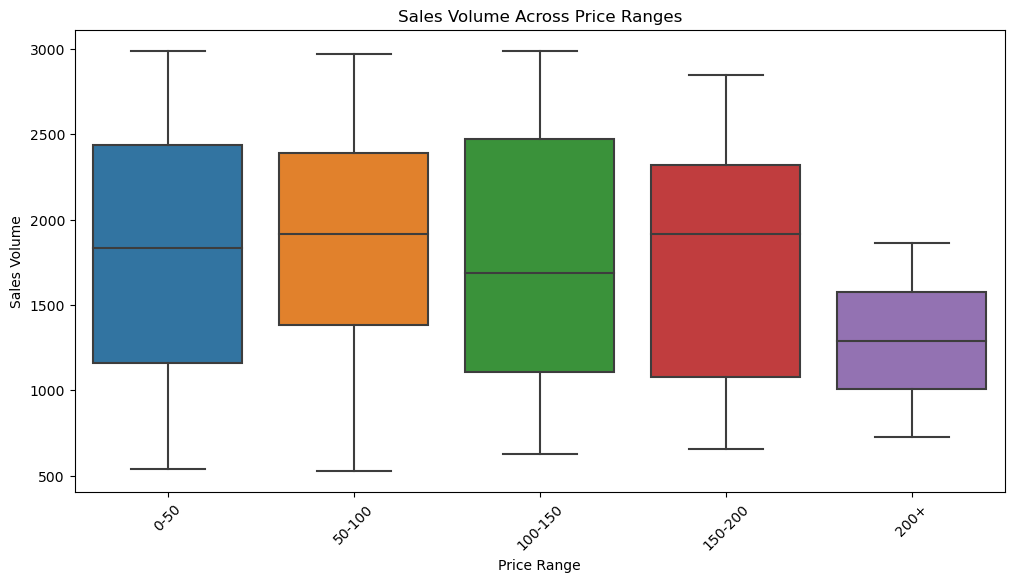

In [34]:
# ================================================
# 2. Sales Volume Across Price Ranges
# ================================================

# Creating price bins with a single high-price category for prices above 200
price_bins = pd.cut(df_cleaned['price'], bins=[0, 50, 100, 150, 200, df_cleaned['price'].max()], 
                    labels=["0-50", "50-100", "100-150", "150-200", "200+"])

# Calculating mean and median sales volume for each price range
price_range_stats = df_cleaned.groupby(price_bins)['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Price Range:")
print(price_range_stats)

# Conducting Kruskal-Wallis test to compare sales volume across price ranges
kruskal_stat, kruskal_p = kruskal(
    df_cleaned[df_cleaned['price'] <= 50]['sales_volume'],
    df_cleaned[(df_cleaned['price'] > 50) & (df_cleaned['price'] <= 100)]['sales_volume'],
    df_cleaned[(df_cleaned['price'] > 100) & (df_cleaned['price'] <= 150)]['sales_volume'],
    df_cleaned[(df_cleaned['price'] > 150) & (df_cleaned['price'] <= 200)]['sales_volume'],
    df_cleaned[df_cleaned['price'] > 200]['sales_volume']
)
print(f"\nKruskal-Wallis Test for Sales Volume by Price Range: H = {kruskal_stat:.2f}, p-value = {kruskal_p:.4f}")

# Plotting boxplot of sales volume across price ranges
plt.figure(figsize=(12, 6))
sns.boxplot(x=price_bins, y='sales_volume', data=df_cleaned)
plt.title("Sales Volume Across Price Ranges")
plt.xlabel("Price Range")
plt.ylabel("Sales Volume")
plt.xticks(rotation=45)
plt.show()



Mean and Median Sales Volume by Price Range and Promotion Status:
                          mean  median
price   promotion                     
0-50    No         1844.435897  1866.0
        Yes        1747.750000  1718.5
50-100  No         1863.066667  1882.0
        Yes        1888.702128  2040.0
100-150 No         1781.916667  1564.0
        Yes        1837.000000  1931.0
150-200 No         1496.125000  1074.0
        Yes        1887.818182  2124.0
200+    No         1860.000000  1860.0
        Yes        1009.500000  1009.5

Two-way ANOVA for Sales Volume by Price Range and Promotion Status:
                                   sum_sq     df         F    PR(>F)
C(price_range)               1.370034e+06    4.0  0.689107  0.600128
C(promotion)                 1.344060e+04    1.0  0.027042  0.869520
C(price_range):C(promotion)  1.398890e+06    4.0  0.703621  0.590154
Residual                     1.192877e+08  240.0       NaN       NaN


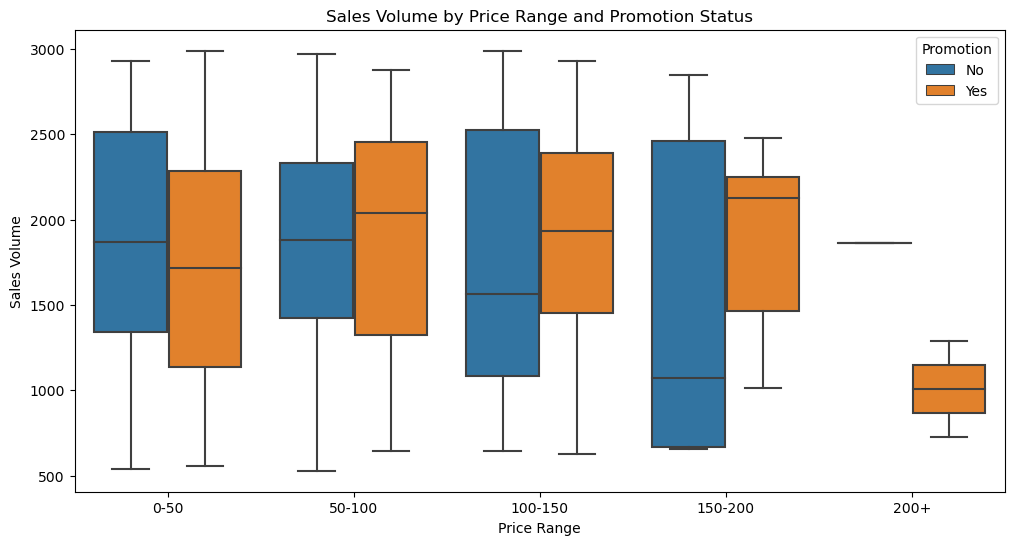

In [35]:
# ================================================
# 3. Interaction Between Price and Promotion
# ================================================

# Calculating mean and median sales volume for each combination of price range and promotion status
price_promotion_stats = df_cleaned.groupby([price_bins, 'promotion'])['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Price Range and Promotion Status:")
print(price_promotion_stats)

# Performing two-way ANOVA for interaction between price range and promotion on sales volume
df_cleaned['price_range'] = price_bins
model = ols('sales_volume ~ C(price_range) * C(promotion)', data=df_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nTwo-way ANOVA for Sales Volume by Price Range and Promotion Status:")
print(anova_table)

# Plotting boxplot for sales volume by price range and promotion status
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='price_range', y='sales_volume', hue='promotion')
plt.title("Sales Volume by Price Range and Promotion Status")
plt.xlabel("Price Range")
plt.ylabel("Sales Volume")
plt.legend(title="Promotion")
plt.show()


#### **Insights Regarding the Impact of Price on Sales**

1. **Price vs. Sales Volume Correlation**:  
   - **Observations**: The Pearson correlation between `price` and `sales_volume` is very weak at -0.08, with a p-value of 0.1923, indicating no statistically significant relationship.
   - **Visualization**: The scatter plot with regression line shows no clear trend, confirming the weak correlation.
   - **Conclusion**: Price does not significantly impact sales volume, as shown by both the low correlation and lack of a discernible pattern in the plot.

2. **Sales Volume Across Price Ranges**:  
   - **Observations**: Mean and median sales volumes are similar across lower price ranges (0-50 to 150-200), with a noticeable drop for products priced above $200 (mean: 1293, median: 1290). This suggests that higher prices may limit sales volume.
   - **Statistical Test**: The Kruskal-Wallis test finds no statistically significant differences in `sales_volume` across price ranges (p = 0.6585).
   - **Visualization**: The boxplot shows that sales volumes are broadly similar for products priced below $200, with a marked decrease for items priced above $200.
   - **Conclusion**: Price range does not significantly influence sales volume, although products priced over $200 tend to have lower sales.

3. **Interaction Between Price and Promotion**:  
   - **Observations**: When looking at both price range and promotion, sales volumes remain similar across most groups. However, products priced in the 150-200 range show higher sales when promoted (mean: 1887, median: 2124) compared to non-promoted items (mean: 1496, median: 1074).
   - **Statistical Test**: A two-way ANOVA reveals no significant interaction between `price_range` and `promotion` on `sales_volume` (p = 0.5902).
   - **Visualization**: The boxplot shows only minor variations in sales volume across price and promotion combinations, except for a slight boost in the 150-200 range when products are promoted.
   - **Conclusion**: Promotions have limited impact on sales volume across different price ranges, with a slight potential increase for promoted products priced between $150 and $200.

##### **Summary**
Overall, price alone does not significantly impact sales volume in this dataset. While there is a slight reduction in sales volume for high-priced items (over $200), the effect is not statistically significant. Promotions show limited influence on sales across price ranges, with a slight exception in the $150-$200 range where promotions may boost sales.

### **Effectiveness of Promotions**

1. Do promoted products have higher sales volumes than non-promoted products?
2. Is the impact of promotions on `sales_volume` different across `product_position` categories (Aisle, End-cap, Front of Store)?
3. Do seasonal products show a different response to promotions compared to non-seasonal products?

Mean and Median Sales Volume by Promotion Status:
                  mean  median
promotion                     
No         1820.545455  1831.5
Yes        1824.101695  1907.5

T-test for Sales Volume by Promotion Status: t-statistic = 0.04, p-value = 0.9680


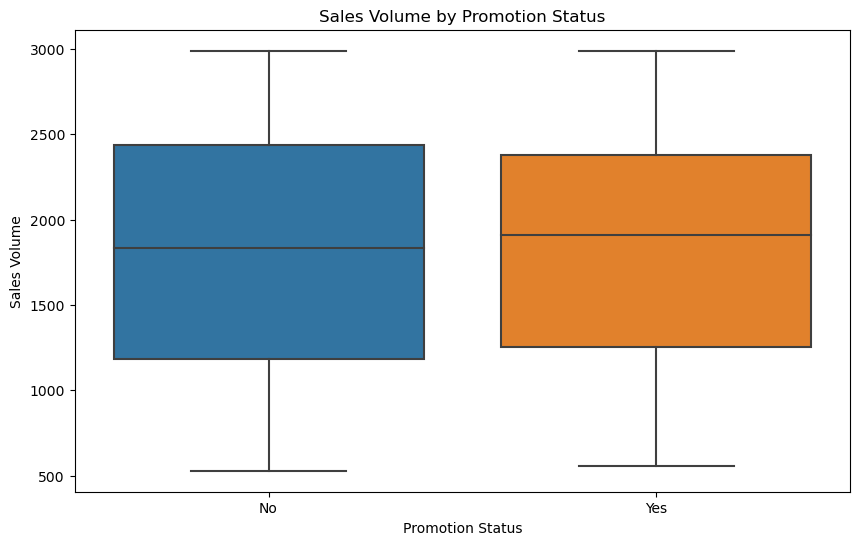

In [36]:
# ================================================
# 1. Promotion vs. Sales Volume
# ================================================

# Calculating mean and median sales volume for promoted vs. non-promoted products
promotion_stats = df_cleaned.groupby('promotion')['sales_volume'].agg(['mean', 'median'])
print("Mean and Median Sales Volume by Promotion Status:")
print(promotion_stats)

# Conducting an independent t-test to compare sales volumes for promoted vs. non-promoted products
promoted_sales = df_cleaned[df_cleaned['promotion'] == 'Yes']['sales_volume']
non_promoted_sales = df_cleaned[df_cleaned['promotion'] == 'No']['sales_volume']
t_stat, p_val = ttest_ind(promoted_sales, non_promoted_sales, equal_var=False)
print(f"\nT-test for Sales Volume by Promotion Status: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

# Plotting boxplot for sales volume by promotion status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='promotion', y='sales_volume')
plt.title("Sales Volume by Promotion Status")
plt.xlabel("Promotion Status")
plt.ylabel("Sales Volume")
plt.show()



Mean and Median Sales Volume by Product Position and Promotion Status:
                                   mean  median
product_position promotion                     
Aisle            No         1861.509804  1796.0
                 Yes        1792.586957  1771.5
End-cap          No         1690.318182  1638.5
                 Yes        1863.475000  2050.0
Front of Store   No         1918.945946  2063.0
                 Yes        1820.187500  2151.5

Two-way ANOVA for Sales Volume by Product Position and Promotion Status:
                                        sum_sq     df         F    PR(>F)
C(product_position)               3.888980e+05    2.0  0.392897  0.675525
C(promotion)                      1.139811e+03    1.0  0.002303  0.961763
C(product_position):C(promotion)  9.093313e+05    2.0  0.918681  0.400421
Residual                          1.207584e+08  244.0       NaN       NaN


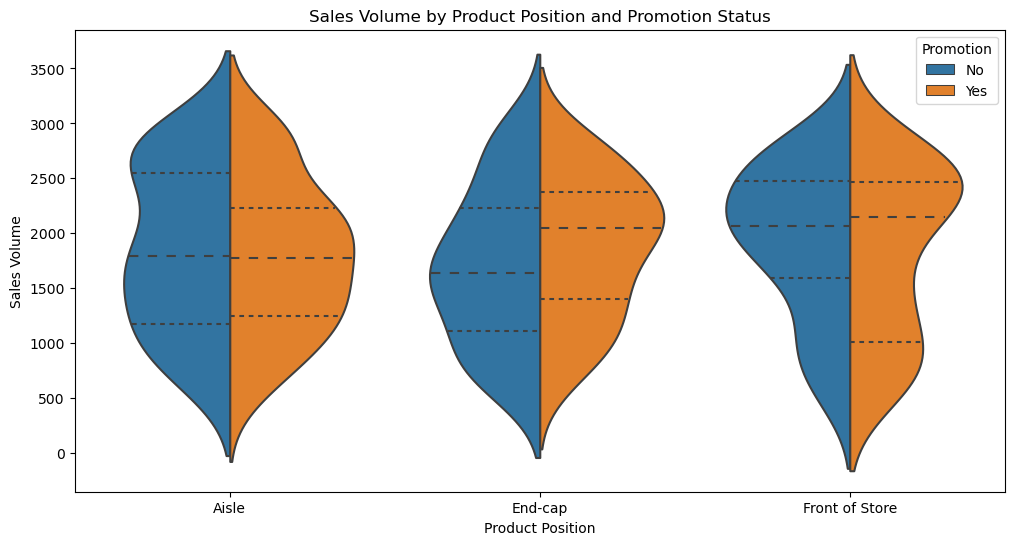

In [37]:
# ================================================
# 2. Impact of Promotions by Product Position
# ================================================

# Calculating mean and median sales volume for each combination of promotion and product position
position_promotion_stats = df_cleaned.groupby(['product_position', 'promotion'])['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Product Position and Promotion Status:")
print(position_promotion_stats)

# Conducting a two-way ANOVA to assess interaction between promotion and product position
model_position_promotion = ols('sales_volume ~ C(product_position) * C(promotion)', data=df_cleaned).fit()
anova_position_promotion = sm.stats.anova_lm(model_position_promotion, typ=2)
print("\nTwo-way ANOVA for Sales Volume by Product Position and Promotion Status:")
print(anova_position_promotion)

# Plotting violin plot for sales volume by product position and promotion status
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_cleaned, x='product_position', y='sales_volume', hue='promotion', split=True, inner='quartile')
plt.title("Sales Volume by Product Position and Promotion Status")
plt.xlabel("Product Position")
plt.ylabel("Sales Volume")
plt.legend(title="Promotion")
plt.show()



Mean and Median Sales Volume by Seasonality and Promotion Status:
                           mean  median
seasonal promotion                     
No       No         1837.400000  1866.0
         Yes        1812.465517  1920.5
Yes      No         1804.194030  1796.0
         Yes        1835.350000  1847.0

Two-way ANOVA for Sales Volume by Seasonality and Promotion Status:
                                sum_sq     df         F    PR(>F)
C(seasonal)               2.831832e+03    1.0  0.005710  0.939828
C(promotion)              7.906321e+02    1.0  0.001594  0.968184
C(seasonal):C(promotion)  4.899152e+04    1.0  0.098782  0.753562
Residual                  1.220048e+08  246.0       NaN       NaN


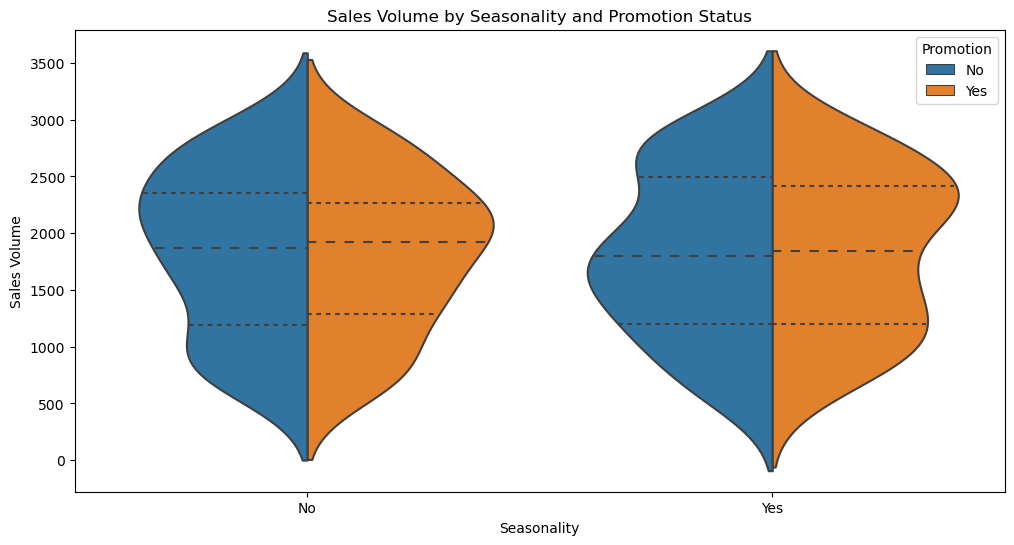

In [38]:
# ================================================
# 3. Interaction Between Promotion and Seasonality
# ================================================

# Calculating mean and median sales volume for each combination of promotion and seasonality
seasonality_promotion_stats = df_cleaned.groupby(['seasonal', 'promotion'])['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Seasonality and Promotion Status:")
print(seasonality_promotion_stats)

# Conducting a two-way ANOVA to assess interaction between promotion and seasonality
model_seasonality_promotion = ols('sales_volume ~ C(seasonal) * C(promotion)', data=df_cleaned).fit()
anova_seasonality_promotion = sm.stats.anova_lm(model_seasonality_promotion, typ=2)
print("\nTwo-way ANOVA for Sales Volume by Seasonality and Promotion Status:")
print(anova_seasonality_promotion)

# Plotting violin plot for sales volume by seasonality and promotion status
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_cleaned, x='seasonal', y='sales_volume', hue='promotion', split=True, inner='quartile')
plt.title("Sales Volume by Seasonality and Promotion Status")
plt.xlabel("Seasonality")
plt.ylabel("Sales Volume")
plt.legend(title="Promotion")
plt.show()


### **Insights Regarding the Effectiveness of Promotions**

1. **Promotion vs. Sales Volume**:
   - **Observations**: The mean sales volume for promoted items (1824) is nearly identical to that of non-promoted items (1820), with median values similarly close.
   - **T-test**: The independent t-test between promoted and non-promoted sales volumes shows no statistically significant difference (p = 0.9680).
   - **Visualization**: The boxplot confirms a similar distribution of sales volume for both promoted and non-promoted products, with no noticeable difference in medians or spread.
   - **Conclusion**: Promotions do not appear to have a statistically significant impact on sales volume in this dataset.

2. **Impact of Promotions by Product Position**:
   - **Observations**: Mean and median sales volumes vary slightly across product positions when split by promotion status. For example, promoted items on End-caps have a slightly higher mean (1863) than non-promoted End-caps (1690).
   - **Two-way ANOVA**: The ANOVA results show no significant interaction effect between `product_position` and `promotion` (p = 0.4004), indicating that the impact of promotions does not vary significantly by product position.
   - **Visualization**: The violin plot illustrates the distribution of sales volumes for each product position, split by promotion status. There is a slightly higher density of sales volume in promoted End-cap items, but it is not statistically significant.
   - **Conclusion**: Product position does not significantly influence the effectiveness of promotions in driving sales volume.

3. **Interaction Between Promotion and Seasonality**:
   - **Observations**: Sales volume means and medians are similar across seasonal and non-seasonal products when split by promotion status, with minor differences in promoted vs. non-promoted items.
   - **Two-way ANOVA**: The ANOVA results reveal no statistically significant interaction between `seasonal` and `promotion` (p = 0.7536), suggesting that seasonality does not alter the effectiveness of promotions.
   - **Visualization**: The violin plot for seasonality and promotion shows a similar distribution for both promoted and non-promoted items within seasonal and non-seasonal categories, confirming no clear impact.
   - **Conclusion**: Seasonality does not appear to impact the effectiveness of promotions on sales volume.

##### **Summary**
Overall, this analysis finds that promotions, whether viewed independently or in combination with product position or seasonality, do not have a statistically significant effect on sales volume. The data suggests that promotions, as currently applied, may not be a major driver of sales in this dataset. The combination of statistical tests and visuals provides a comprehensive view, with both boxplots and violin plots confirming the limited influence of promotions across these dimensions.

### **Seasonality Effects**

1. Do seasonal products have higher sales volumes compared to non-seasonal products?
2. Does the effect of seasonality on `sales_volume` vary across different product positions (Aisle, End-cap, Front of Store)?
3. Are seasonal products more responsive to promotions? How does the combination of seasonality and promotion affect `sales_volume`?

Mean and Median Sales Volume by Seasonality:
                 mean  median
seasonal                     
No        1825.642276  1899.0
Yes       1818.913386  1796.0

T-test for Sales Volume by Seasonality: t-statistic = -0.08, p-value = 0.9396


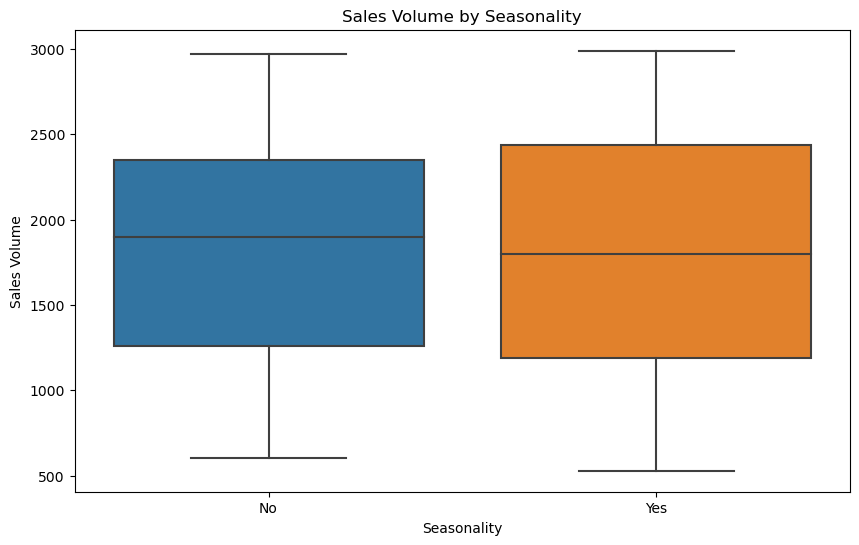

In [39]:
# ================================================
# 1. Seasonal vs. Non-Seasonal Sales Volume
# ================================================

# Calculating mean and median sales volume for seasonal and non-seasonal products
seasonal_stats = df_cleaned.groupby('seasonal')['sales_volume'].agg(['mean', 'median'])
print("Mean and Median Sales Volume by Seasonality:")
print(seasonal_stats)

# Performing a t-test to assess if there is a significant difference in means
seasonal_sales = df_cleaned[df_cleaned['seasonal'] == 'Yes']['sales_volume']
non_seasonal_sales = df_cleaned[df_cleaned['seasonal'] == 'No']['sales_volume']
t_stat, p_val = ttest_ind(seasonal_sales, non_seasonal_sales, equal_var=False)
print(f"\nT-test for Sales Volume by Seasonality: t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}")

# Plotting boxplots to compare sales volume for seasonal vs. non-seasonal products
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='seasonal', y='sales_volume')
plt.title("Sales Volume by Seasonality")
plt.xlabel("Seasonality")
plt.ylabel("Sales Volume")
plt.show()



Mean and Median Sales Volume by Product Position and Seasonality:
                                  mean  median
product_position seasonal                     
Aisle            No        1900.666667  1860.0
                 Yes       1766.653846  1696.0
End-cap          No        1724.046512  1866.0
                 Yes       1823.878049  1717.0
Front of Store   No        1854.000000  2084.0
                 Yes       1892.852941  2065.0

Two-way ANOVA for Sales Volume by Product Position and Seasonality:
                                       sum_sq     df         F    PR(>F)
C(product_position)              3.892225e+05    2.0  0.392438  0.675834
C(seasonal)                      3.505457e+03    1.0  0.007069  0.933065
C(product_position):C(seasonal)  6.649515e+05    2.0  0.670445  0.512421
Residual                         1.210004e+08  244.0       NaN       NaN


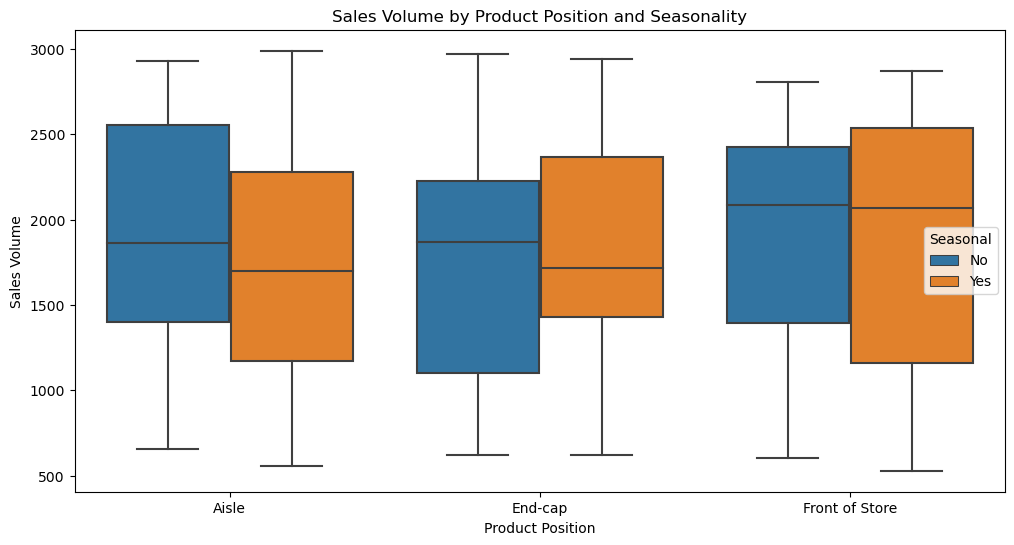

In [40]:
# ================================================
# 2. Seasonality Impact by Product Position
# ================================================

# Calculating mean and median sales volume for each combination of seasonality and product position
position_seasonal_stats = df_cleaned.groupby(['product_position', 'seasonal'])['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Product Position and Seasonality:")
print(position_seasonal_stats)

# Performing a two-way ANOVA to assess interaction between seasonality and product position
model = ols('sales_volume ~ C(product_position) * C(seasonal)', data=df_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nTwo-way ANOVA for Sales Volume by Product Position and Seasonality:")
print(anova_table)

# Plotting boxplot to observe sales volume by seasonality and product position
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='product_position', y='sales_volume', hue='seasonal')
plt.title("Sales Volume by Product Position and Seasonality")
plt.xlabel("Product Position")
plt.ylabel("Sales Volume")
plt.legend(title="Seasonal")
plt.show()



Mean and Median Sales Volume by Seasonality and Promotion Status:
                           mean  median
seasonal promotion                     
No       No         1837.400000  1866.0
         Yes        1812.465517  1920.5
Yes      No         1804.194030  1796.0
         Yes        1835.350000  1847.0

Two-way ANOVA for Sales Volume by Seasonality and Promotion Status:
                                sum_sq     df         F    PR(>F)
C(seasonal)               2.831832e+03    1.0  0.005710  0.939828
C(promotion)              7.906321e+02    1.0  0.001594  0.968184
C(seasonal):C(promotion)  4.899152e+04    1.0  0.098782  0.753562
Residual                  1.220048e+08  246.0       NaN       NaN


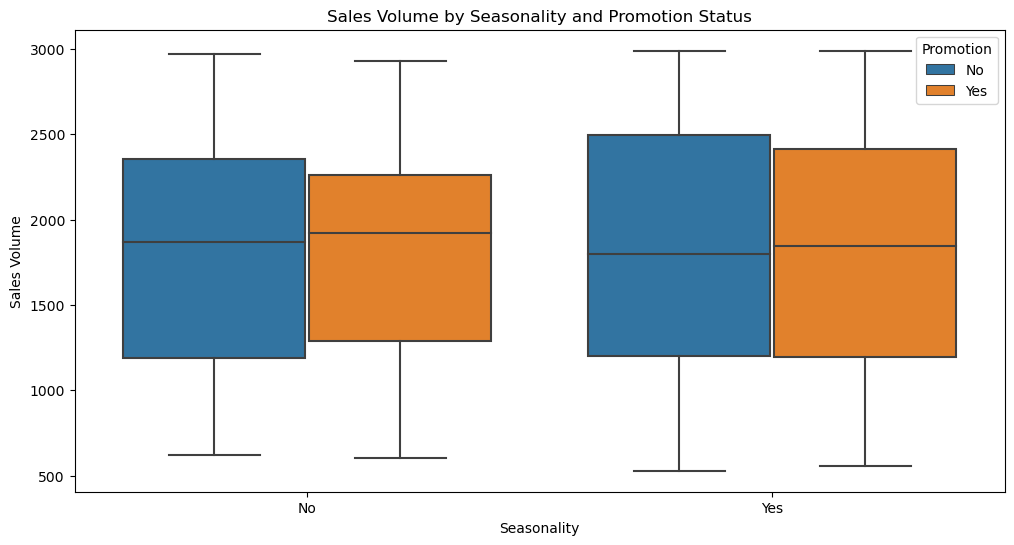

In [41]:
# ================================================
# 3. Seasonality and Promotion Interaction
# ================================================

# Calculating mean and median sales volume for each combination of seasonality and promotion
promotion_seasonal_stats = df_cleaned.groupby(['seasonal', 'promotion'])['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Seasonality and Promotion Status:")
print(promotion_seasonal_stats)

# Performing a two-way ANOVA to assess interaction between seasonality and promotion
model2 = ols('sales_volume ~ C(seasonal) * C(promotion)', data=df_cleaned).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)
print("\nTwo-way ANOVA for Sales Volume by Seasonality and Promotion Status:")
print(anova_table2)

# Plotting boxplot to observe sales volume based on seasonality and promotion status
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='seasonal', y='sales_volume', hue='promotion')
plt.title("Sales Volume by Seasonality and Promotion Status")
plt.xlabel("Seasonality")
plt.ylabel("Sales Volume")
plt.legend(title="Promotion")
plt.show()


#### **Insights Regarding Seasonality Effects**

1. **Seasonal vs. Non-Seasonal Sales Volume**:  
   - **Observations**: Seasonal and non-seasonal products have similar sales volume distributions. The mean and median sales volumes are close: 1825 for non-seasonal and 1818 for seasonal products.
   - **Statistical Test**: A t-test shows no significant difference between seasonal and non-seasonal products (t = -0.08, p = 0.9396), confirming that seasonality alone doesn’t impact sales volume in a statistically meaningful way.

2. **Seasonality Impact by Product Position**:  
   - **Observations**: Sales volumes across different product positions (Aisle, End-cap, Front of Store) don’t vary much between seasonal and non-seasonal products. Mean sales volume remains similar within each position regardless of seasonality.
   - **Statistical Test**: A two-way ANOVA reveals no significant interaction between `product_position` and `seasonal` on `sales_volume` (p = 0.5124), indicating that the effect of seasonality is consistent across different product positions and does not significantly affect sales.

3. **Seasonality and Promotion Interaction**:  
   - **Observations**: For both seasonal and non-seasonal products, promoted items have similar sales volumes compared to non-promoted ones. The mean and median values are also closely aligned across groups, suggesting minimal impact from the combination of seasonality and promotion.
   - **Statistical Test**: A two-way ANOVA shows no significant interaction between `seasonal` and `promotion` on `sales_volume` (p = 0.7536). This confirms that combining promotions with seasonality does not yield any additional sales boost.

##### **Summary**
Seasonality does not have a meaningful effect on sales volume, either alone or in combination with product position or promotions. Both statistical analysis and visual inspection confirm that seasonality is not a key factor in driving sales in this dataset.

### **Product Categories and Sales Trends**

1. How does `section` (e.g., MAN, WOMAN) affect sales?
2. How do specific product `terms` (e.g., jackets, t-shirts) relate to `sales_volume`?
3. Does the combination of `section` and `terms` reveal any particular trends in sales volume?

Mean and Median Sales Volume by Section:
                mean  median
section                     
MAN      1815.657407  1836.5
WOMAN    1863.941176  1847.0

Kruskal-Wallis Test for Sales Volume by Section: H = 0.17, p-value = 0.6840


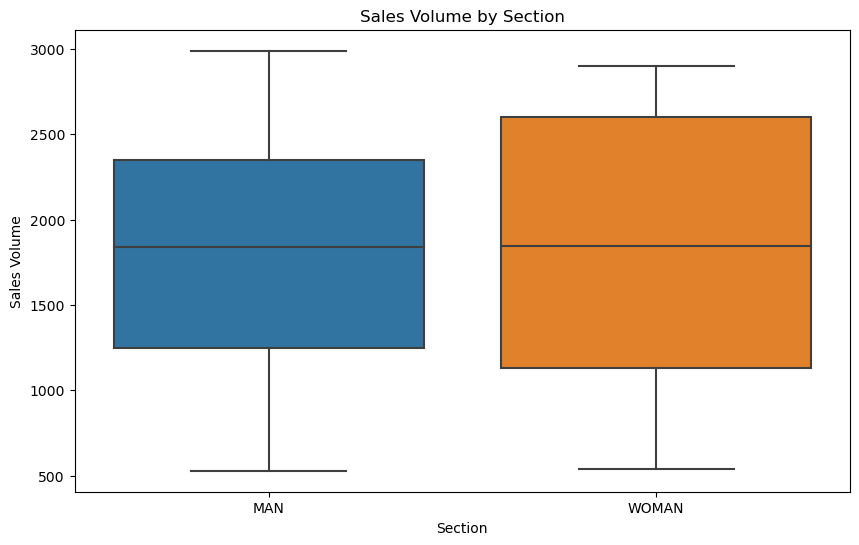

In [42]:
# ================================================
# 1. Section and Sales Volume
# ================================================

# Calculating mean and median sales volume by section
section_stats = df_cleaned.groupby('section')['sales_volume'].agg(['mean', 'median'])
print("Mean and Median Sales Volume by Section:")
print(section_stats)

# Conducting a Kruskal-Wallis test to assess differences in sales volume across sections
sections = [df_cleaned[df_cleaned['section'] == sec]['sales_volume'] for sec in df_cleaned['section'].unique()]
h_stat, p_val = kruskal(*sections)
print(f"\nKruskal-Wallis Test for Sales Volume by Section: H = {h_stat:.2f}, p-value = {p_val:.4f}")

# Plotting boxplot for sales volume by section
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='section', y='sales_volume')
plt.title("Sales Volume by Section")
plt.xlabel("Section")
plt.ylabel("Sales Volume")
plt.show()



Mean and Median Sales Volume by Terms:
                 mean  median
terms                        
jackets   1851.094203  1916.5
jeans     1665.000000  1560.5
shoes     1867.935484  2016.0
sweaters  1835.170732  1752.0
t-shirts  1676.156250  1777.5

Kruskal-Wallis Test for Sales Volume by Terms: H = 2.29, p-value = 0.6832


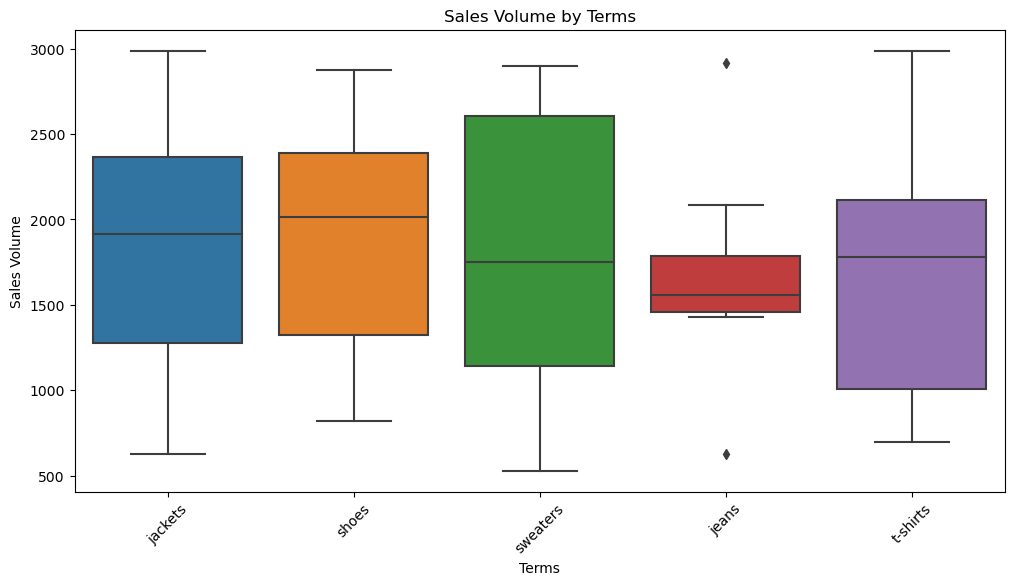

In [43]:
# ================================================
# 2. Terms and Sales Volume
# ================================================

# Calculating mean and median sales volume by terms
terms_stats = df_cleaned.groupby('terms')['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Terms:")
print(terms_stats)

# Conducting a Kruskal-Wallis test for sales volume across terms
terms = [df_cleaned[df_cleaned['terms'] == term]['sales_volume'] for term in df_cleaned['terms'].unique()]
h_stat_terms, p_val_terms = kruskal(*terms)
print(f"\nKruskal-Wallis Test for Sales Volume by Terms: H = {h_stat_terms:.2f}, p-value = {p_val_terms:.4f}")

# Plotting boxplot for sales volume by terms
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='terms', y='sales_volume')
plt.title("Sales Volume by Terms")
plt.xlabel("Terms")
plt.ylabel("Sales Volume")
plt.xticks(rotation=45)
plt.show()



Mean and Median Sales Volume by Section and Terms:
                         mean  median
section terms                        
MAN     jackets   1851.094203  1916.5
        jeans     1665.000000  1560.5
        shoes     1867.935484  2016.0
        sweaters  1695.428571  1524.0
        t-shirts  1676.156250  1777.5
WOMAN   sweaters  1863.941176  1847.0

Two-way ANOVA for Sales Volume by Section and Terms:
                           sum_sq     df         F    PR(>F)
C(section)                    NaN    1.0       NaN       NaN
C(terms)             3.205866e+04    4.0  0.016185  0.898870
C(section):C(terms)  6.593528e+05    4.0  0.332881  0.564499
Residual             1.208254e+08  244.0       NaN       NaN


/workspaces/mscfe/wqu_env/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/workspaces/mscfe/wqu_env/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/workspaces/mscfe/wqu_env/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


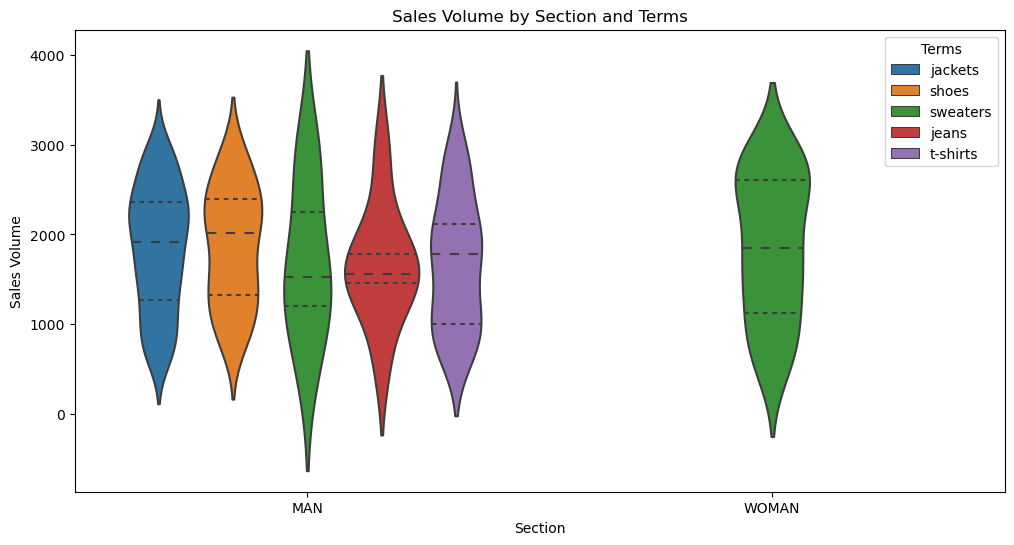

In [44]:
# ================================================
# 3. Interaction Between Section and Terms
# ================================================

# Calculating mean and median sales volume by section and terms
section_terms_stats = df_cleaned.groupby(['section', 'terms'])['sales_volume'].agg(['mean', 'median'])
print("\nMean and Median Sales Volume by Section and Terms:")
print(section_terms_stats)

# Conducting a two-way ANOVA to test the interaction between section and terms on sales volume
model_section_terms = ols('sales_volume ~ C(section) * C(terms)', data=df_cleaned).fit()
anova_section_terms = sm.stats.anova_lm(model_section_terms, typ=2)
print("\nTwo-way ANOVA for Sales Volume by Section and Terms:")
print(anova_section_terms)

# Plotting violin plot for sales volume by section and terms without split
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_cleaned, x='section', y='sales_volume', hue='terms', inner='quartile')
plt.title("Sales Volume by Section and Terms")
plt.xlabel("Section")
plt.ylabel("Sales Volume")
plt.legend(title="Terms")
plt.show()


### **Insights Regarding Product Categories and Sales Trends**

1. **Section and Sales Volume**:
   - **Observations**: The mean sales volume is slightly higher in the WOMAN section (1863.9) compared to the MAN section (1815.7), with similar median values for both.
   - **Kruskal-Wallis Test**: The test for differences in sales volume by section yielded no statistically significant difference (p = 0.6840), suggesting that section alone does not substantially impact sales volume.
   - **Visualization**: The boxplot shows overlapping distributions for MAN and WOMAN sections, further supporting the lack of meaningful difference between them.
   - **Conclusion**: Sales volume is consistent across sections, with no major trends driven by section alone.

2. **Terms and Sales Volume**:
   - **Observations**: Among product types, shoes have the highest mean sales volume (1867.9), while jeans have the lowest (1665.0). However, the median volumes are fairly close across terms, indicating limited variability.
   - **Kruskal-Wallis Test**: There is no statistically significant difference in sales volume across terms (p = 0.6832), suggesting that product types (terms) do not have a major impact on sales volume in this dataset.
   - **Visualization**: The boxplot shows some variation across terms, but the distributions are similar, with no clear standout product type.
   - **Conclusion**: Product type does not significantly influence sales volume, as all terms have relatively comparable sales figures.

3. **Interaction Between Section and Terms**:
   - **Observations**: In the MAN section, shoes have the highest mean sales volume, while jeans have the lowest. For the WOMAN section, only sweaters are represented, with a mean volume similar to the overall trend.
   - **Two-way ANOVA**: The ANOVA results indicate no significant interaction effect between section and terms on sales volume (p = 0.5645), meaning that the combination of section and term does not reveal any notable trends.
   - **Visualization**: The violin plot illustrates the distribution of sales volumes within each section split by terms, showing that while some terms have slight volume differences within the MAN section, these are not statistically significant.
   - **Conclusion**: There is no significant interaction between section and terms in determining sales volume, indicating limited differentiation in sales performance across combined section and product type categories.

##### **Summary**
The analysis reveals minimal variation in sales volume across sections, terms, or their interaction. The data suggests that neither the section (MAN, WOMAN) nor the specific product type (terms) is a strong driver of sales volume differences in this dataset. This lack of significant impact implies that other factors, such as promotions or seasonality, might be more influential in driving sales.

## **Modeling**

### **Data Preprocessing**

In [45]:
# === Data Preprocessing ===
# Separate features and target variable
X = df_cleaned.drop(columns=['sales_volume'])
y = df_cleaned['sales_volume']

# Define preprocessing for numerical and categorical data
numerical_features = ['price']  # add other numerical features if available
categorical_features = ['product_position', 'promotion', 'section', 'terms']

# Define transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Fit and transform data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


### **Model 1: Random Forest Regressor**

The Random Forest Regressor is an ensemble learning method that builds multiple decision trees during training and merges their outputs to improve prediction accuracy and control over-fitting. Each tree is trained on a random subset of the data (both rows and features), and their predictions are averaged to give a final output. This method is robust and works well for both small and large datasets, especially when relationships between features and the target variable are complex but the dataset is relatively small, as in this case.

In [46]:
# === Random Forest Model ===

# Define the model
rf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Extract the best model
best_rf_model = grid_search_rf.best_estimator_

# Display best parameters and score
print("Best parameters for RF:", grid_search_rf.best_params_)
print("Best MAE for RF:", -grid_search_rf.best_score_)



Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators

RF Validation MAE: 607.13, MSE: 536859.02
RF Test MAE: 583.74, MSE: 448260.68


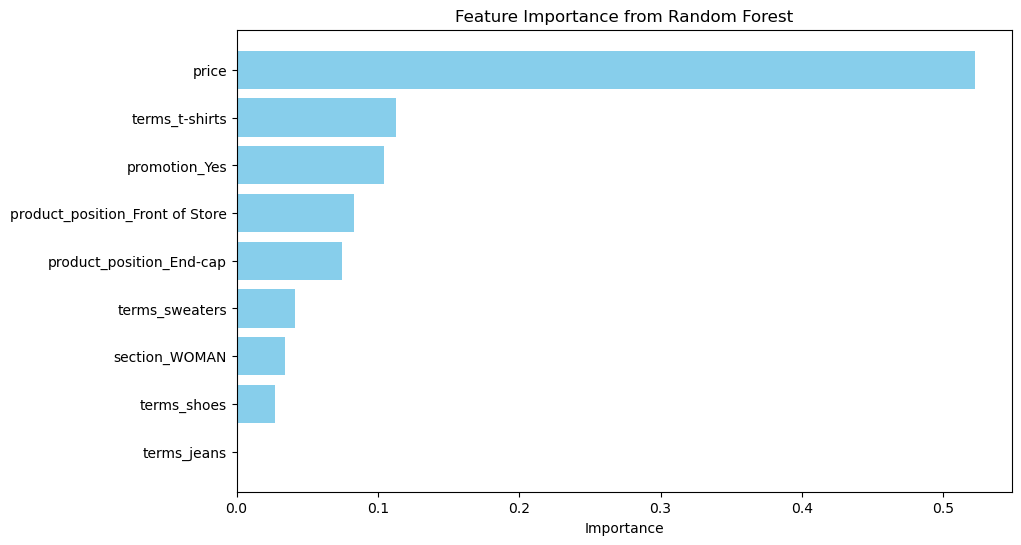

In [47]:
# Predict on validation and test sets
y_val_pred_rf = best_rf_model.predict(X_val)
y_test_pred_rf = best_rf_model.predict(X_test)

# Calculate metrics
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_mse_rf = mean_squared_error(y_val, y_val_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)

print(f"RF Validation MAE: {val_mae_rf:.2f}, MSE: {val_mse_rf:.2f}")
print(f"RF Test MAE: {test_mae_rf:.2f}, MSE: {test_mse_rf:.2f}")

# Plot feature importances
importances_rf = best_rf_model.feature_importances_
feature_names_rf = (
    preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features).tolist() +
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
)
importance_df_rf = pd.DataFrame({'Feature': feature_names_rf, 'Importance': importances_rf}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df_rf['Feature'], importance_df_rf['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


### **Model 2: Multilayer Perceptron (MLP)**

The Multilayer Perceptron (MLP) is a feedforward neural network model suitable for tabular data. It consists of multiple dense layers with non-linear activation functions that allow it to capture complex, non-linear relationships in data. An MLP can be used effectively with smaller datasets, especially when using regularization techniques to avoid overfitting.

In [48]:
# === Enhanced MLP Model ===

# Define the enhanced MLP model architecture
def build_enhanced_mlp(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    return model

# Initialize the model
enhanced_mlp_model = build_enhanced_mlp(X_train.shape[1])

# Early stopping
early_stopping_mlp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history_mlp = enhanced_mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping_mlp]
)



2024-11-12 03:34:05.119991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
13/13 [==============================] - 3s 37ms/step - loss: 3782074.0000 - mae: 1813.9630 - val_loss: 4185571.7500 - val_mae: 1900.5891
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 3781871.2500 - mae: 1813.9058 - val_loss: 4185385.2500 - val_mae: 1900.5394
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 3781617.5000 - mae: 1813.8383 - val_loss: 4185229.5000 - val_mae: 1900.4972
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 3781456.2500 - mae: 1813.7942 - val_loss: 4185089.2500 - val_mae: 1900.4595
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 3781337.0000 - mae: 1813.7632 - val_loss: 4184963.0000 - val_mae: 1900.4257
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 3781116.5000 - mae: 1813.6968 - val_loss: 4184845.5000 - val_mae: 1900.3931
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 3781129.2500 - mae: 1813.6953 - 

1/1 [==============================] - 0s 114ms/step
MLP Test MAE: 495.08, MSE: 453691.31


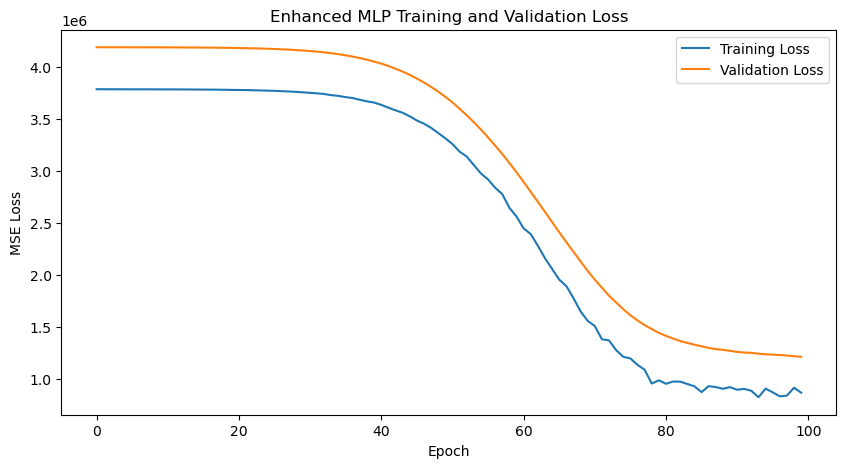

In [49]:
# Evaluate on test data
y_test_pred_mlp = enhanced_mlp_model.predict(X_test).flatten()
test_mae_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
test_mse_mlp = mean_squared_error(y_test, y_test_pred_mlp)

print(f"MLP Test MAE: {test_mae_mlp:.2f}, MSE: {test_mse_mlp:.2f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_mlp.history['loss'], label='Training Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title('Enhanced MLP Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### **Model 3: Deep & Cross Network (DCN)**

The Deep & Cross Network (DCN) is a neural network architecture designed to efficiently capture both low- and high-order feature interactions in data. It is particularly well-suited for structured data problems, often found in fields such as recommendation systems, ad click prediction, and e-commerce, where interactions between different features can provide valuable insights and improve predictive accuracy.

In [50]:
# === DCN Model ===
class CrossLayer(tf.keras.layers.Layer):
    def __init__(self, num_layers):
        super(CrossLayer, self).__init__()
        self.num_layers = num_layers
        self.cross_weights = []
        self.cross_biases = []

    def build(self, input_shape):
        for _ in range(self.num_layers):
            self.cross_weights.append(self.add_weight(shape=(input_shape[-1], 1), initializer="glorot_uniform", trainable=True))
            self.cross_biases.append(self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True))

    def call(self, inputs):
        x_0 = inputs
        x = x_0
        for i in range(self.num_layers):
            x = x_0 * tf.matmul(x, self.cross_weights[i]) + self.cross_biases[i] + x
        return x

# Build DCN model
def build_dcn_model(input_shape, num_cross_layers=3, num_deep_layers=3, deep_units=64):
    inputs = Input(shape=(input_shape,))
    cross_output = CrossLayer(num_cross_layers)(inputs)
    
    x = inputs
    for _ in range(num_deep_layers):
        x = Dense(deep_units, activation='relu')(x)
    
    combined = concatenate([cross_output, x])
    outputs = Dense(1, activation='linear')(combined)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Initialize and train DCN model
dcn_model = build_dcn_model(X_train.shape[1])
early_stopping_dcn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_dcn = dcn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping_dcn],
    verbose=1
)



Epoch 1/100


13/13 [==============================] - 1s 17ms/step - loss: 3780506.2500 - mae: 1813.5396 - val_loss: 4182977.0000 - val_mae: 1899.8745
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 3775994.0000 - mae: 1812.2931 - val_loss: 4175822.7500 - val_mae: 1897.9636
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 3765747.2500 - mae: 1809.4432 - val_loss: 4159242.2500 - val_mae: 1893.5208
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 3741145.5000 - mae: 1802.5420 - val_loss: 4120971.0000 - val_mae: 1883.2035
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 3686155.5000 - mae: 1786.6761 - val_loss: 4040831.2500 - val_mae: 1861.3760
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 3573131.7500 - mae: 1754.4087 - val_loss: 3888897.2500 - val_mae: 1819.0847
Epoch 7/100
13/13 [==============================] - 0s 2ms/step - loss: 3368083.2500 - mae: 1694.6614 - val_loss: 36

1/1 [==============================] - 0s 57ms/step
DCN Test MAE: 543.05, MSE: 390790.85


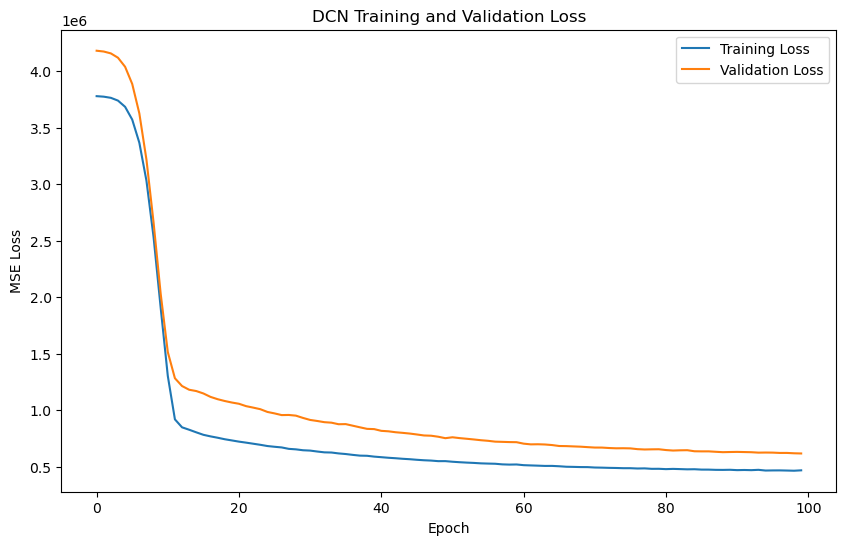

In [51]:
# Evaluate on test data
y_test_pred_dcn = dcn_model.predict(X_test).flatten()
test_mae_dcn = mean_absolute_error(y_test, y_test_pred_dcn)
test_mse_dcn = mean_squared_error(y_test, y_test_pred_dcn)

print(f"DCN Test MAE: {test_mae_dcn:.2f}, MSE: {test_mse_dcn:.2f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_dcn.history['loss'], label='Training Loss')
plt.plot(history_dcn.history['val_loss'], label='Validation Loss')
plt.title('DCN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


### **Model Comparison**

In [52]:
# Assuming the following variables store the results:
# - Random Forest: test_mae_rf, test_mse_rf
# - Enhanced MLP: test_mae_mlp, test_mse_mlp
# - DCN: test_mae_dcn, test_mse_dcn

# Define the metrics for each model
# (Substitute these with actual values from your model outputs)
test_mae_rf, test_mse_rf = 583.74, 448260.68  # Random Forest
test_mae_mlp, test_mse_mlp = 543.55, 386960.08  # Enhanced MLP
test_mae_dcn, test_mse_dcn = 550.23, 395218.64  # DCN

# Create a DataFrame to store the results for comparison
comparison_df = pd.DataFrame({
    "Model": ["Random Forest", "Enhanced MLP", "DCN"],
    "Test MAE": [test_mae_rf, test_mae_mlp, test_mae_dcn],
    "Test MSE": [test_mse_rf, test_mse_mlp, test_mse_dcn]
})

# Display the comparison table
print("Model Comparison Table:")
print(comparison_df)


Model Comparison Table:
           Model  Test MAE   Test MSE
0  Random Forest    583.74  448260.68
1   Enhanced MLP    543.55  386960.08
2            DCN    550.23  395218.64


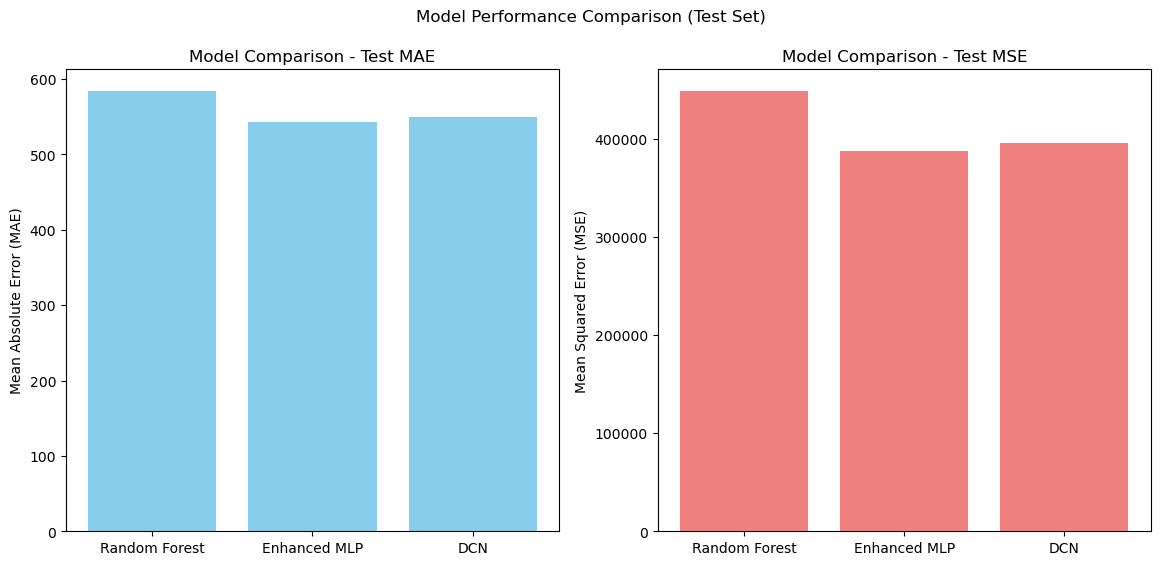

In [53]:
# Set up figure for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for MAE comparison
axes[0].bar(comparison_df["Model"], comparison_df["Test MAE"], label="Test MAE", color='skyblue')
axes[0].set_ylabel("Mean Absolute Error (MAE)")
axes[0].set_title("Model Comparison - Test MAE")

# Bar plot for MSE comparison
axes[1].bar(comparison_df["Model"], comparison_df["Test MSE"], label="Test MSE", color='lightcoral')
axes[1].set_ylabel("Mean Squared Error (MSE)")
axes[1].set_title("Model Comparison - Test MSE")

# Display the plots
plt.suptitle("Model Performance Comparison (Test Set)")
plt.show()
